In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import os
import time

import matplotlib
import matplotlib.pyplot as plt
#plt.style.use("ggplot")

import numpy as np
import pandas as pd

sys.path.append(os.path.join(os.getcwd(),"migration-lib"))
import MigrationDataUSA
import MigrationModels
import EvaluationMethods

sys.path.append(os.path.join(os.getcwd(),"simple-maps"))
from simplemaps.SimpleFigures import simpleMap, differenceMap

# Initial setup

In [2]:
# Location of US County shapefile used for creating the maps
shapefileFn = "simple-maps/examples/cb_2015_us_county_500k_clipped/cb_2015_us_county_500k_clipped.shp"
shapefileKey = "GEOID"

# Load data

### Migration data

In [3]:
countyList = []
f = open("data/migration/largestCountyIntersection_2004_2014.txt")
for line in f.read().strip().split("\n"):
    countyList.append(line)
f.close()
county_to_idx = {county:idx for idx, county in enumerate(countyList)}
numberOfCounties = len(countyList)

In [4]:
county_to_name = {}
county_to_state = {}
f = open("data/co-est00int-tot.csv","r")
print(f.readline().strip())
for line in f:
    parts = line.strip().split(",")
    sumlev, region, division, state, county, stname, ctyname = parts[:7]
    county_fips = "%02d%03d" % (int(state), int(county))
    county_to_name[county_fips] = ctyname
    county_to_state[county_fips] = stname
f.close()

SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010


### Per county features

In [5]:
df_medium = pd.read_csv("data/affected_population_medium.csv")
df_high = pd.read_csv("data/affected_population_high.csv")

In [6]:
medium_years = [2055, 2080, 2100]
high_years = [2042, 2059, 2071, 2082, 2091, 2100]

medium_total_pop = [
    df_medium["Total Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_affected_pop = [
    df_medium["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in medium_years
]
medium_unaffected_pop = [
    medium_total_pop[i] - medium_affected_pop[i]
    for i in range(len(medium_years))
]

high_total_pop = [
    df_high["Total Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_affected_pop = [
    df_high["Affected Population %d" % (year)].values.reshape(-1,1)
    for year in high_years
]
high_unaffected_pop = [
    high_total_pop[i] - high_affected_pop[i]
    for i in range(len(high_years))
]

In [7]:
medium_affected_counties = [
    (affected_population > 0).reshape(-1)
    for affected_population in medium_affected_pop
]

high_affected_counties = [
    (affected_population > 0).reshape(-1)
    for affected_population in high_affected_pop
]

# DL Results

In [12]:
medium_baseline_migration = [np.load("output/dl_medium_baseline_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration = [np.load("output/dl_medium_affected_results_%d.npy" % (year)) for year in medium_years]
medium_ablation_migration = [np.load("output/dl_medium_ablation_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration_flooded = [np.load("output/dl_medium_affected_results_flooded_%d.npy" % (year)) for year in medium_years]
medium_affected_migration_unflooded = [np.load("output/dl_medium_affected_results_unflooded_%d.npy" % (year)) for year in medium_years]


high_baseline_migration = [np.load("output/dl_high_baseline_results_%d.npy" % (year)) for year in high_years]
high_affected_migration = [np.load("output/dl_high_affected_results_%d.npy" % (year)) for year in high_years]
high_ablation_migration = [np.load("output/dl_high_ablation_results_%d.npy" % (year)) for year in high_years]
high_affected_migration_flooded = [np.load("output/dl_high_affected_results_flooded_%d.npy" % (year)) for year in high_years]
high_affected_migration_unflooded = [np.load("output/dl_high_affected_results_unflooded_%d.npy" % (year)) for year in high_years]

model = "dl"

# ExtRad Results

In [17]:
medium_baseline_migration = [np.load("output/extrad_medium_baseline_results_%d.npy" % (year)) for year in medium_years]
medium_affected_migration = [np.load("output/extrad_medium_affected_results_%d.npy" % (year)) for year in medium_years]
medium_ablation_migration = [np.load("output/extrad_medium_ablation_results_%d.npy" % (year)) for year in medium_years]

high_baseline_migration = [np.load("output/extrad_high_baseline_results_%d.npy" % (year)) for year in high_years]
high_affected_migration = [np.load("output/extrad_high_affected_results_%d.npy" % (year)) for year in high_years]
high_ablation_migration = [np.load("output/extrad_high_ablation_results_%d.npy" % (year)) for year in high_years]

model = "extrad"

# Medium

In [11]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    
    count = 0
    for j, county in enumerate(countyList):
        if t_affected_incoming[j] - t_baseline_incoming[j] > 0:
            count += 1
            
    print(year, count / float(len(countyList)))

(2055, 1.0)
(2080, 1.0)
(2100, 1.0)


In [13]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
        if not medium_affected_counties[i][j]
    }
    map_data["46102"] = 0        

    simpleMap(
        shapefileFn,
        shapefileKey,
        map_data,
        outputFn="figures/%s_difference_both_medium_%d.png" % (model, year),
        noDataColor="#0000FFFF",
        cmap="Reds",
        bounds=[22, 49, -119, -64],
        title="Direct and Indirect Effects, Medium %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
    )

/usr/local/lib/python2.7/dist-packages/mpl_toolkits/basemap/__init__.py:1698: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch


### Affected

In [14]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i][medium_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i][medium_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefileFn,
        shapefileKey,
        map_data,
        outputFn="figures/%s_difference_affected_medium_%d.png" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        title="Difference in Incoming Migrants from Affected Areas, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
    )

### Unnaffected

In [15]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i][~medium_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i][~medium_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefileFn,
        shapefileKey,
        map_data,
        outputFn="figures/%s_difference_unaffected_medium_%d.png" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        title="Difference in Incoming Migrants from Unaffected Areas, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
    )

### Abalation

In [18]:
for i,year in enumerate(medium_years):

    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_ablation_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefileFn,
        shapefileKey,
        map_data,
        outputFn="figures/%s_difference_ablation_medium_%d.png" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        title="ExtRad Ablation, Medium %d" % (year),
        colorbarRange=(1e1, 1e5),
        logScale=True,
    )

# High

In [17]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    
    count = 0
    for j, county in enumerate(countyList):
        if t_affected_incoming[j] - t_baseline_incoming[j] > 0:
            count += 1
            
    print(year, count / float(len(countyList)))

(2042, 0.8766902768834514)
(2059, 0.8396651641983258)
(2071, 0.8486799742433999)
(2082, 0.8721828718609144)
(2091, 0.9256278171281391)
(2100, 0.9993560849967804)


In [16]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
        if not high_affected_counties[i][j]
    }
    map_data["46102"] = 0

    simpleMap(
        shapefileFn,
        shapefileKey,
        map_data,
        outputFn="figures/%s_difference_both_high_%d.png" % (model, year),
        noDataColor="#0000FFFF",
        cmap="Reds",
        bounds=[22, 49, -119, -64],
        title="Direct and Indirect Effects, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
    )

### Affected

In [17]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i][high_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i][high_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefileFn,
        shapefileKey,
        map_data,
        outputFn="figures/%s_difference_affected_high_%d.png" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        title="Difference in Incoming Migrants from Affected Areas, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
    )

### Unaffected

In [23]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i][~high_affected_counties[i],:].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i][~high_affected_counties[i],:].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefileFn,
        shapefileKey,
        map_data,
        outputFn="figures/%s_difference_unaffected_high_%d.png" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        title="Difference in Incoming Migrants from Unaffected Areas, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
    )

### Ablation

In [19]:
for i,year in enumerate(high_years):

    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_ablation_migration[i].sum(axis=0)
    
    map_data = {
        county: t_affected_incoming[j] - t_baseline_incoming[j]
        for j, county in enumerate(countyList)
    }
    map_data["46102"] = 0

    differenceMap(
        shapefileFn,
        shapefileKey,
        map_data,
        outputFn="figures/%s_difference_ablation_high_%d.png" % (model, year),
        #noDataColor="#0000FFFF",
        #cmap="Reds",
        bounds=[22, 49, -119, -64],
        title="ExtRad Ablation, High %d" % (year),
        colorbarRange=(1e2, 1e6),
        logScale=True,
    )

# Indirect Effect Thresholds

## High

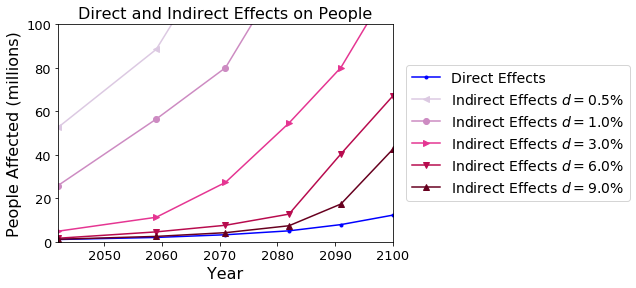

In [18]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
ys_direct = []
ys_thresholds = [[] for threshold in thresholds]
divisor = 1000000.0

for i, year in enumerate(high_years):

    direct_effect = high_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming

    for j, threshold in enumerate(thresholds):
        
        t_pop = high_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))        
        ys_thresholds[j].append(direct_effect + (t_pop[indirect_mask].sum() / divisor))
    
markers = [".", "<", "o", ">", "v", "^", "D"]
cmap = matplotlib.cm.get_cmap("PuRd")
norm = matplotlib.colors.Normalize(vmin=0,vmax=len(thresholds))
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
plt.figure()

plt.plot(high_years, ys_direct, color="b", marker=markers[0], label="Direct Effects")

for j, threshold in enumerate(thresholds):
    plt.plot(high_years, ys_thresholds[j], color=sm.to_rgba(j+1), marker=markers[j+1], label=r"Indirect Effects $d = %0.1f \%% $" % (threshold))

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=14)
plt.subplots_adjust(right=0.9)

plt.xticks(fontsize=13)
plt.xlim([2042,2100])
plt.xlabel("Year", fontsize=16)

plt.yticks(fontsize=13)
plt.ylim([0,100])
plt.ylabel("People Affected (millions)", fontsize=16)

plt.title("Direct and Indirect Effects on People", fontsize=16)
plt.savefig("figures/%s_direct_indirect_high_plot.png" % (model), dpi=150, bbox_inches="tight")
plt.show()
plt.close()

In [41]:
ys_thresholds

[[57.985063910655995,
  119.24231026009099,
  185.253791558354,
  243.64019085955204,
  317.968655988233,
  480.08164263938704],
 [23.508422086292,
  61.471791389808004,
  101.89402293286199,
  157.331980414229,
  247.33992531947698,
  357.440362542294],
 [3.5277222559840005,
  9.560812125275,
  22.796253709081,
  46.740419958283,
  73.414257934579,
  120.06695729162399],
 [1.2945913434890002,
  3.3302094300280003,
  7.464808543506,
  13.992093458697,
  26.547415248969997,
  43.226918504085],
 [1.0533413937340002,
  2.2239153797410003,
  4.326651753395001,
  7.981509032648001,
  13.647178801249998,
  25.551774014331002]]

In [19]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
labels = [
    "Directly Affected"
] + [">%0.1f%%" % (threshold) for threshold in thresholds] + ["Not Affected"]

cmap = matplotlib.colors.ListedColormap(
    ["#0000FFFF"] + [sm.to_rgba(j+1) for j in range(len(thresholds))] + ["#FFFFFFFF"],
    N = len(labels)
)
hackMapping = {
    i:i for i in range(len(labels))
}

for i, year in enumerate(high_years):
    
    direct_effect = high_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  high_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  high_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming
    
    t_map = (high_affected_pop[i] > 0).reshape(-1).astype(int)
    t_mask = (high_affected_pop[i] > 0).reshape(-1)

    for j, threshold in enumerate(thresholds):
        
        t_pop = high_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))
        t_map[indirect_mask] = j+2
    
    t_map[t_map==0] = len(thresholds) + 2
    t_map -= 1
    t_map[t_mask] = 0
    print(np.unique(t_map, return_counts=True))
 
    map_data = {
        county: t_map[j]
        for j, county in enumerate(countyList)
    }
    map_data["46102"] = 6

    
    simpleMap(
        shapefileFn, shapefileKey,
        map_data,
        cmap=cmap,
        outputFn="figures/%s_direct_indirect_high_%d.png" % (model, year),
        colorbarType=1,
        colorbarLabels=labels,
        dataToColorIdxMap=hackMapping,
        bounds=[22, 49, -119, -64],
        title="Direct and Indirect Effects at different thresholds, High %d" % (year)
    )

(array([0, 1, 2, 3, 4, 6]), array([ 336,   19,    8,    3,    1, 2739]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 340,   78,   14,    2,    3,    1, 2668]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 341,  132,   50,    3,    3,    1, 2576]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 345,  221,   92,    4,    3,    2, 2439]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 346,  307,  208,   13,    5,    2, 2225]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 349,  658,  380,   54,    5,    8, 1652]))


## Medium

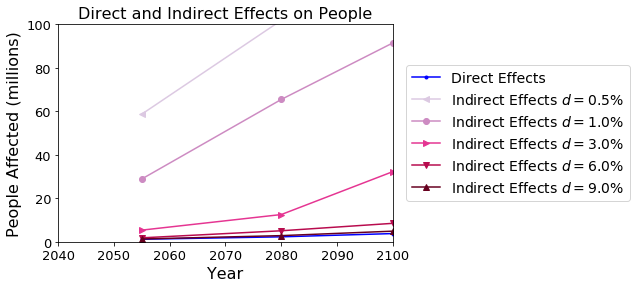

In [20]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
ys_direct = []
ys_thresholds = [[] for threshold in thresholds]
divisor = 1000000.0

for i, year in enumerate(medium_years):

    direct_effect = medium_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming

    for j, threshold in enumerate(thresholds):
        
        t_pop = medium_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))        
        ys_thresholds[j].append(direct_effect + (t_pop[indirect_mask].sum() / divisor))
    
markers = [".", "<", "o", ">", "v", "^", "D"]
cmap = matplotlib.cm.get_cmap("PuRd")
norm = matplotlib.colors.Normalize(vmin=0,vmax=len(thresholds))
sm = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
    
plt.figure()

plt.plot(medium_years, ys_direct, color="b", marker=markers[0], label="Direct Effects")

for j, threshold in enumerate(thresholds):
    plt.plot(medium_years, ys_thresholds[j], color=sm.to_rgba(j+1), marker=markers[j+1], label=r"Indirect Effects $d = %0.1f \%% $" % (threshold))

plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, fontsize=14)
plt.subplots_adjust(right=0.9)

plt.xticks(fontsize=13)
plt.xlim([2040,2100])
plt.xlabel("Year", fontsize=16)

plt.yticks(fontsize=13)
plt.ylim([0,100])
plt.ylabel("People Affected (millions)", fontsize=16)

plt.title("Direct and Indirect Effects on People", fontsize=16)
plt.savefig("figures/%s_direct_indirect_medium_plot.png" % (model), dpi=150, bbox_inches="tight")
plt.show()
plt.close()

In [21]:
ys_thresholds

[[58.70677374632599, 101.85777043917399, 157.45619581855698],
 [28.892934828401, 65.46574208064301, 91.476565400273],
 [5.3677172314599995, 12.533612128514, 32.277556251058996],
 [1.8209733742640002, 5.075730630133, 8.495586954431001],
 [1.295195403393, 2.8393124429360004, 4.896272840141001]]

In [22]:
thresholds = [0.5, 1.0, 3.0, 6.0, 9.0]
labels = [
    "Directly Affected"
] + [">%0.1f%%" % (threshold) for threshold in thresholds] + ["Not Affected"]

cmap = matplotlib.colors.ListedColormap(
    ["#0000FFFF"] + [sm.to_rgba(j+1) for j in range(len(thresholds))] + ["#FFFFFFFF"],
    N = len(labels)
)
hackMapping = {
    i:i for i in range(len(labels))
}

for i, year in enumerate(medium_years):
    
    direct_effect = medium_affected_pop[i].sum() / divisor
    ys_direct.append(direct_effect)
    
    t_affected_incoming =  medium_affected_migration[i].sum(axis=0)
    t_baseline_incoming =  medium_baseline_migration[i].sum(axis=0)
    t_increase = t_affected_incoming - t_baseline_incoming
    
    t_map = (medium_affected_pop[i] > 0).reshape(-1).astype(int)
    t_mask = (medium_affected_pop[i] > 0).reshape(-1)

    for j, threshold in enumerate(thresholds):
        
        t_pop = medium_total_pop[i].copy().reshape(-1)
        indirect_mask = t_increase > (t_pop * (threshold/100.0))
        t_map[indirect_mask] = j+2
    
    t_map[t_map==0] = len(thresholds) + 2
    t_map -= 1
    t_map[t_mask] = 0
    print(np.unique(t_map, return_counts=True))
 
    map_data = {
        county: t_map[j]
        for j, county in enumerate(countyList)
    }
    map_data["46102"] = 6

    
    simpleMap(
        shapefileFn, shapefileKey,
        map_data,
        cmap=cmap,
        outputFn="figures/%s_direct_indirect_medium_%d.png" % (model, year),
        colorbarType=1,
        colorbarLabels=labels,
        dataToColorIdxMap=hackMapping,
        bounds=[22, 49, -119, -64],
        title="Direct and Indirect Effects at different thresholds, Medium %d" % (year)
    )

(array([0, 1, 2, 3, 4, 6]), array([ 336,   20,    8,    3,    1, 2738]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 340,   76,   13,    2,    3,    1, 2671]))
(array([0, 1, 2, 3, 4, 5, 6]), array([ 341,  125,   44,    3,    3,    1, 2589]))
